# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/"Colab Notebooks"/ADL/HW4/Q2

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ADL/HW4/Q2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from vanilla_backprop import VanillaBackprop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset

In [ ]:
mean , std = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

batch_size = 64
input_size = 32

train_data = torchvision.datasets.CIFAR10(root= './data', train = True,download =True, transform = transform)
test_data = torchvision.datasets.CIFAR10(root= './data', train = False,download =True, transform = transform)
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True)
test_loader_1=torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=True)
n_train=len(train_data)
n_test=len(test_data)
classes = train_data.classes

Files already downloaded and verified
Files already downloaded and verified


# Model

In [ ]:
def unnormalize(img, mean = np.array(mean), std = np.array(std)):
  inverse_mean = - mean/std
  inverse_std = 1/std
  img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
  return img

def normalize(img, mean = np.array(mean), std = np.array(std)):
  return transforms.Normalize(mean = mean, std = std)(img)
  
def get_num_correct(out, labels):
    return out.argmax(dim=1).eq(labels).sum().item()

model=models.vgg19(pretrained=True)
model.classifier[-1]=nn.Linear(4096, len(classes))

model=model.to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Training

In [ ]:
epoch_num = 10
best_acc = 0
train_loss=[]
test_loss=[]
test_accuracy=[]

for epoch in range(epoch_num):
    train_loss_tmp = 0
    test_loss_tmp = 0
    test_accuracy_tmp = 0
    model.train()
    for batch, (images,labels) in enumerate(train_loader):
        images,labels=images.to(device),labels.to(device)
        outs=model(images)
        loss=F.cross_entropy(outs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_tmp+=loss.item()
    train_loss_tmp /= n_train
    
    model.eval()
    with torch.no_grad():
      for (images,labels) in test_loader:
          images,labels = images.to(device),labels.to(device)
          outs = model(images)
          test_loss_tmp += F.cross_entropy(outs,labels).item()
          test_accuracy_tmp += get_num_correct(outs,labels)
    test_loss_tmp /= n_test
    test_accuracy_tmp /= n_test
    
    train_loss.append(train_loss_tmp)
    test_loss.append(test_loss_tmp)
    test_accuracy.append(test_accuracy_tmp)
    print(f"Epoch {epoch + 1}/{epoch_num}: train_loss= {train_loss_tmp:>7f} test_Avg_loss= {test_loss_tmp:>8f} test_acc= {100*test_accuracy_tmp:>0.1f}%")
    if test_accuracy_tmp > best_acc:
      torch.save(model, './models/vgg19.pth')
      print(f"test acc improved from {best_acc} to {test_accuracy_tmp} and model saved!")
      best_acc = test_accuracy_tmp

Epoch 1/10: train_loss= 0.011623 test_Avg_loss= 0.009882 test_acc= 78.5%
test acc improved from 0 to 0.7847 and model saved!
Epoch 2/10: train_loss= 0.006943 test_Avg_loss= 0.007822 test_acc= 83.8%
test acc improved from 0.7847 to 0.8382 and model saved!
Epoch 3/10: train_loss= 0.005379 test_Avg_loss= 0.006921 test_acc= 85.4%
test acc improved from 0.8382 to 0.8537 and model saved!
Epoch 4/10: train_loss= 0.004456 test_Avg_loss= 0.006650 test_acc= 85.9%
test acc improved from 0.8537 to 0.8591 and model saved!
Epoch 5/10: train_loss= 0.003689 test_Avg_loss= 0.006077 test_acc= 87.4%
test acc improved from 0.8591 to 0.8742 and model saved!
Epoch 6/10: train_loss= 0.003068 test_Avg_loss= 0.012137 test_acc= 79.0%
Epoch 7/10: train_loss= 0.002550 test_Avg_loss= 0.005716 test_acc= 88.7%
test acc improved from 0.8742 to 0.8871 and model saved!
Epoch 8/10: train_loss= 0.002151 test_Avg_loss= 0.007063 test_acc= 86.3%
Epoch 9/10: train_loss= 0.001782 test_Avg_loss= 0.005800 test_acc= 89.5%
test a

In [ ]:
model = torch.load('./models/vgg19.pth',map_location='cpu')
model=model.to(device)

# Visualize Gradient

In [ ]:
from torch.nn import ReLU

class GuidedBackprop():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)

        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<Figure size 144x864 with 0 Axes>

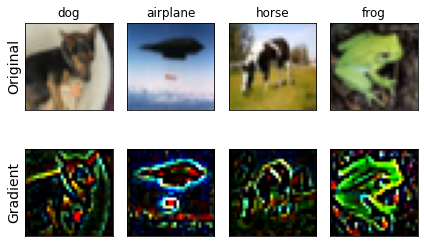

In [ ]:
model.eval()
model.cpu()
GBP = VanillaBackprop(model)
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 4)
for i,(img,label) in enumerate(test_loader_1):
    if i+1>4 : break    
    img.requires_grad=True
    pred = model(img.cpu())
    pred_label = int(pred.argmax(1).cpu().numpy())
    GBP = GuidedBackprop(model.cpu())
    vanilla_grads  = GBP.generate_gradients(img, pred_label)
    img = unnormalize(img).detach().numpy()
    img = np.clip(img, 0., 1.)[0]
    img = np.transpose(img, (1,2,0))
    vanilla_grads = np.clip(vanilla_grads, 0., 1.)
    vanilla_grads = np.transpose(vanilla_grads, (1,2,0))
    ax1 = axs[0, i]
    ax2 = axs[1, i]
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax1.imshow(img)
    ax2.imshow(vanilla_grads)
    ax1.set_title(classes[label])
    if i == 0:
        ax1.set_ylabel('Original', fontsize=14)
        ax2.set_ylabel('Gradient', fontsize=14)
plt.tight_layout()
plt.show()

# Testing

In [ ]:
model.eval()
model = model.to(device)
test_accuracy = 0
with torch.no_grad():
  for (images,labels) in test_loader:
      images,labels = images.to(device),labels.to(device)
      outs = model(images)
      test_accuracy += get_num_correct(outs,labels)
test_accuracy /= n_test
print(f"Accuracy of the trained vgg19 model: {(100*test_accuracy):>0.1f}%")

Accuracy of the trained vgg19 model: 89.3%


# FGSM

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  if epsilon == 0:
    return image
  else:
    image = unnormalize(image)
    pertubed_image = image + epsilon*data_grad.sign()
    pertubed_image = torch.clamp(pertubed_image,0,1)
    pertubed_image = transforms.Normalize(mean = mean, std = std)(pertubed_image)
    return pertubed_image.float()

In [ ]:
epsilon = 0.1
n_examples = 4
examples = []
accuracies = []

correct = 0
adv_examples = []
adv_dataset = []
model.eval()
model = model.to(device)
for i, (data, target) in enumerate(test_loader_1):
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, epsilon, data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
    adv_ex = perturbed_data.squeeze().detach().cpu()
    ori_ex = data.squeeze().detach().cpu()
    adv_examples.append([init_pred.item(), final_pred.item(), adv_ex, ori_ex])
final_acc = correct/float(len(test_loader_1))
print("Test Accuracy = {} / {} = {} \n".format(correct, len(test_loader_1), final_acc))

Test Accuracy = 893 / 10000 = 0.0893 



<Figure size 144x864 with 0 Axes>

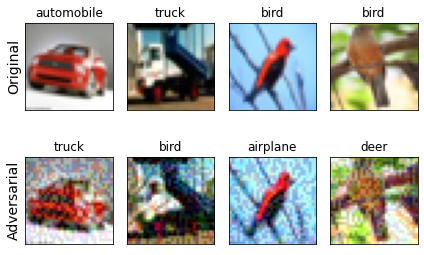

In [ ]:
def ax_imshow(ax, img, label):
    img = unnormalize(img)
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])
n_examples=4
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, n_examples)
for j in range(n_examples): 
    orig,adv,adv_ex,ori_ex = adv_examples[j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax2, adv_ex, adv)
    ax_imshow(ax1, ori_ex, orig)
    if j == 0:
        ax1.set_ylabel('Original', fontsize=14)
        ax2.set_ylabel('Adversarial', fontsize=14)
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<Figure size 144x864 with 0 Axes>

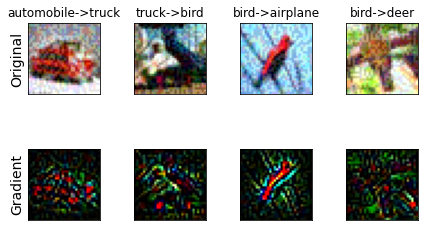

In [ ]:
model.eval()
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 4)
for i,(orig,adv,adv_ex,ori_ex) in enumerate(adv_examples[:n_examples]):
    img = torch.tensor(adv_ex).to(device)
    img.requires_grad=True
    img=img.unsqueeze(0)
    model.to(device)
    pred = model(img)
    pred_label = pred.argmax(1)
    GBP = GuidedBackprop(model.cpu())
    vanilla_grads  = GBP.generate_gradients(img.cpu(), pred_label.cpu())
    img = unnormalize(img.cpu()).detach().numpy()
    img = np.clip(img, 0., 1.)[0]
    img = np.transpose(img, (1,2,0))
    vanilla_grads = np.clip(vanilla_grads, 0., 1.)
    vanilla_grads = np.transpose(vanilla_grads, (1,2,0))
    ax1 = axs[0, i]
    ax2 = axs[1, i]
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax1.imshow(img)
    ax2.imshow(vanilla_grads)
    ax1.set_title("{}->{}".format(classes[orig],classes[adv]))
    if i == 0:
        ax1.set_ylabel('Original', fontsize=14)
        ax2.set_ylabel('Gradient', fontsize=14)
plt.tight_layout()
plt.show()

 # Defence against adversarial

In [ ]:
epoch_num = 5
model.train()
model.to(device)
for epoch in range(10):
    for orig,adv,adv_ex,ori_ex in adv_examples:
        image,label=ori_ex.to(device),torch.tensor(orig).unsqueeze(0).to(device)
        image.requires_grad = True
        outs=model(image.unsqueeze(0))
        loss=F.nll_loss(outs,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        adv_ex=adv_ex.to(device)
        preds = model(adv_ex.unsqueeze(0))
        loss = F.nll_loss(preds, label)
        loss.backward()
        optimizer.step()
    print(epoch)

0
1
2
3


KeyboardInterrupt: ignored

In [ ]:
model.eval()
model.to(device)
correct=0
with torch.no_grad():
    for orig,adv,adv_ex,ori_ex in adv_examples:        
        images = adv_ex.to(device)
        outs = model(images.unsqueeze(0))
        correct += get_num_correct(outs,orig)

In [ ]:
correct/len(adv_examples)

0.1